In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import re
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm

# Load all TensorBoard data once
base_path = "/home/azhuravl/scratch/mlp_probes/tensorboard"
tensorboard_data = {}

print("Loading TensorBoard data...")
base_path = Path(base_path)

tb_files = list(base_path.rglob("events.out.tfevents.*"))
for event_file in tqdm(tb_files):
    # Extract hyperparameters from path
    path_parts = event_file.parts
    
    # Find timestep and layer name from path structure
    timestep = None
    layer_name = None
    
    # Look for timestep_X pattern
    for i, part in enumerate(path_parts):
        if part.startswith('timestep_'):
            timestep = int(part.split('_')[1])
            # The next folder should be the layer name
            if i + 1 < len(path_parts):
                layer_name = path_parts[i + 1]
            break
    
    if timestep is None or layer_name is None:
        continue
    
    # Load tensorboard data
    try:
        ea = EventAccumulator(str(event_file.parent))
        ea.Reload()
        
        # Store the event accumulator with metadata
        key = (timestep, layer_name)
        tensorboard_data[key] = {
            'accumulator': ea,
            'timestep': timestep,
            'layer_name': layer_name,
            'path': str(event_file.parent)
        }
        
    except Exception as e:
        print(f"Error loading {event_file}: {e}")
        continue

print(f"Loaded {len(tensorboard_data)} experiments")
print(f"Available configurations: {list(tensorboard_data.keys())}")

# Analyze the available timesteps and layer names
timesteps = set()
layer_names = set()

for (timestep, layer_name) in tensorboard_data.keys():
    timesteps.add(timestep)
    layer_names.add(layer_name)

print(f"Available timesteps: {sorted(timesteps)}")
print(f"Available layer names: {sorted(layer_names)}")

# Check what metrics are available across all experiments
all_metrics = set()
for config, data in tensorboard_data.items():
    scalar_tags = data['accumulator'].Tags()['scalars']
    all_metrics.update(scalar_tags)

print(f"Available metrics across all experiments: {sorted(all_metrics)}")

Loading TensorBoard data...


100%|██████████| 120/120 [00:10<00:00, 11.46it/s]

Loaded 60 experiments
Available configurations: [(199, 'transformer_block_8'), (199, 'pos_embed'), (199, 'transformer_block_24'), (199, 'cross_attn_1'), (199, 'transformer_block_32'), (199, 'cross_attn_2'), (199, 'cross_attn_0'), (199, 'final_norm'), (199, 'transformer_block_40'), (199, 'transformer_block_16'), (839, 'cross_attn_2'), (839, 'cross_attn_0'), (839, 'cross_attn_1'), (839, 'transformer_block_40'), (839, 'pos_embed'), (839, 'transformer_block_24'), (839, 'final_norm'), (839, 'transformer_block_8'), (839, 'transformer_block_32'), (839, 'transformer_block_16'), (519, 'cross_attn_1'), (519, 'transformer_block_40'), (519, 'transformer_block_16'), (519, 'cross_attn_2'), (519, 'transformer_block_32'), (519, 'cross_attn_0'), (519, 'transformer_block_8'), (519, 'transformer_block_24'), (519, 'final_norm'), (519, 'pos_embed'), (359, 'transformer_block_16'), (359, 'cross_attn_2'), (359, 'transformer_block_32'), (359, 'cross_attn_0'), (359, 'final_norm'), (359, 'cross_attn_1'), (359, '

In [7]:
def extract_multiple_metrics(tensorboard_data, metric_names, exact_match=False):
    """
    Extract multiple metrics from all loaded TensorBoard data.
    
    Args:
        tensorboard_data: Dictionary of loaded TensorBoard data
        metric_names: List of metric names to extract
        exact_match: If False, does case-insensitive substring matching
    
    Returns:
        DataFrame with columns: timestep, layer_name, metric_name, metric_value, step, wall_time
    """
    results = []
    
    for (timestep, layer_name), data in tensorboard_data.items():
        ea = data['accumulator']
        scalar_tags = ea.Tags()['scalars']
        
        for metric_name in metric_names:
            # Find the metric
            target_tag = None
            if exact_match:
                target_tag = metric_name if metric_name in scalar_tags else None
            else:
                # Case insensitive substring search
                for tag in scalar_tags:
                    if metric_name.lower() in tag.lower():
                        target_tag = tag
                        break
            
            if target_tag:
                scalar_events = ea.Scalars(target_tag)
                
                for event in scalar_events:
                    results.append({
                        'timestep': timestep,
                        'layer_name': layer_name,
                        'metric_name': metric_name,
                        # 'actual_tag': target_tag,
                        'metric_value': event.value,
                        # 'step': event.step,
                        # 'wall_time': event.wall_time
                    })
            else:
                print(f"Metric '{metric_name}' not found for config ({timestep}, {layer_name})")
    
    df = pd.DataFrame(results)
    return df

# Example usage:
# Extract multiple metrics
metrics_to_extract = ['final_test_rel_error', 
                      'final_train_rel_error', 
                      'generalization_gap_rel_error', 
                      ]
df = extract_multiple_metrics(tensorboard_data, metrics_to_extract)

# Save to CSV
# df.to_csv('tensorboard_metrics.csv', index=False)
print(f"Extracted {len(df)} data points across {len(metrics_to_extract)} metrics")

df.head()

Extracted 180 data points across 3 metrics


,timestep,layer_name,metric_name,metric_value
0,199,transformer_block_8,final_test_rel_error,31.342495
1,199,transformer_block_8,final_train_rel_error,30.354874
2,199,transformer_block_8,generalization_gap_rel_error,0.987621
3,199,pos_embed,final_test_rel_error,35.886993
4,199,pos_embed,final_train_rel_error,29.535505


In [9]:
layer_order = [
    'pos_embed',
    'cross_attn_0',
    'transformer_block_8',
    'cross_attn_1',
    'transformer_block_16',
    'transformer_block_24',
    'cross_attn_2',
    'transformer_block_32',
    'transformer_block_40',
    'final_norm',
]

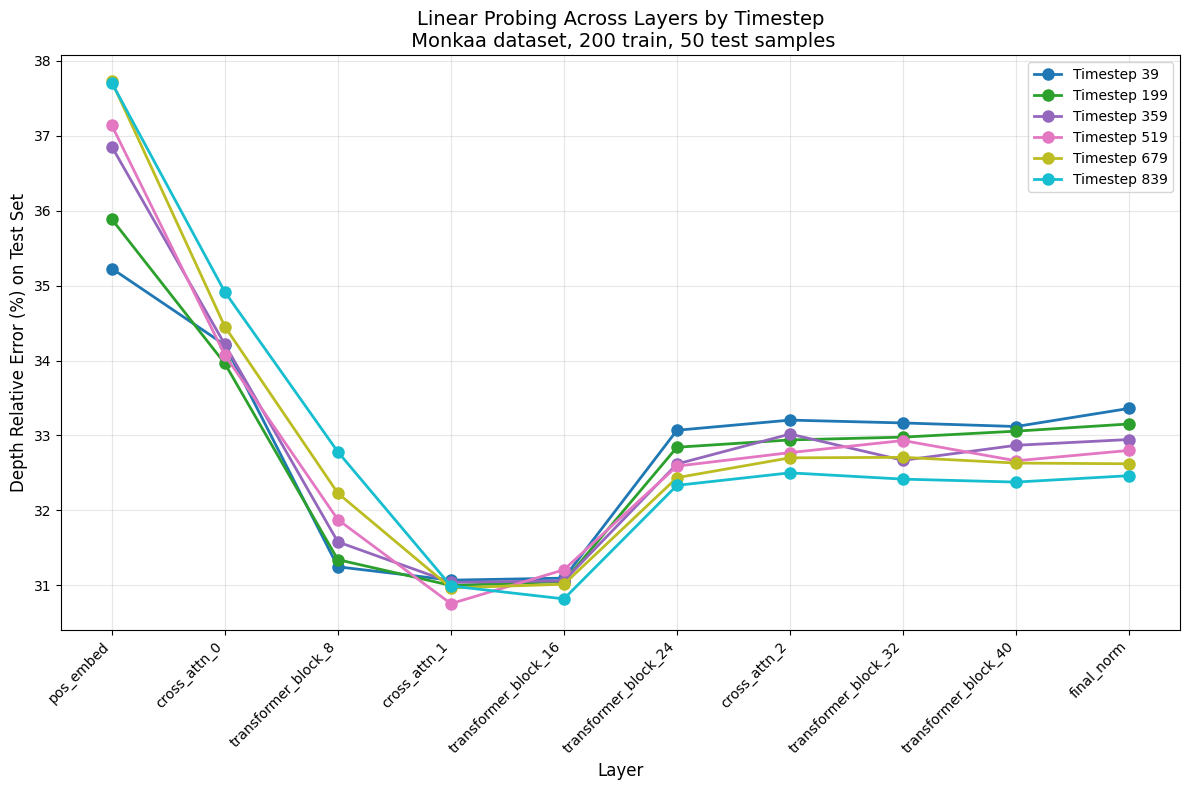

Summary of final_test_rel_error by timestep and layer:
timestep                    39         199        359        519        679  \
layer_name                                                                    
pos_embed             35.228676  35.886993  36.855804  37.140060  37.725445   
cross_attn_0          34.209560  33.961285  34.215992  34.074707  34.453861   
transformer_block_8   31.247093  31.342495  31.579550  31.876621  32.229866   
cross_attn_1          31.069008  30.998587  31.039457  30.755123  30.965509   
transformer_block_16  31.095835  31.050573  31.059290  31.207361  31.014723   
transformer_block_24  33.069588  32.842911  32.619415  32.590843  32.437141   
cross_attn_2          33.205200  32.940586  33.019184  32.771210  32.701714   
transformer_block_32  33.167210  32.977921  32.668194  32.932526  32.708225   
transformer_block_40  33.119637  33.057636  32.868961  32.662357  32.631660   
final_norm            33.361279  33.153572  32.946095  32.800625  32.622231 

In [15]:
import numpy as np

def extract_single_metric(tensorboard_data, metric_name, exact_match=False):
    """
    Extract a single metric from all loaded TensorBoard data.
    """
    results = []
    
    for (timestep, layer_name), data in tensorboard_data.items():
        ea = data['accumulator']
        scalar_tags = ea.Tags()['scalars']
        
        # Find the metric
        target_tag = None
        if exact_match:
            target_tag = metric_name if metric_name in scalar_tags else None
        else:
            # Case insensitive substring search
            for tag in scalar_tags:
                if metric_name.lower() in tag.lower():
                    target_tag = tag
                    break
        
        if target_tag:
            scalar_events = ea.Scalars(target_tag)
            # Get the final value (last step)
            if scalar_events:
                final_event = scalar_events[-1]
                results.append({
                    'timestep': timestep,
                    'layer_name': layer_name,
                    'metric_value': final_event.value,
                    'step': final_event.step,
                    'actual_tag': target_tag
                })
    
    return pd.DataFrame(results)

# Extract the metric
metric_df = extract_single_metric(tensorboard_data, 'final_test_rel_error')

# Filter to only include layers that are in our defined order
metric_df = metric_df[metric_df['layer_name'].isin(layer_order)]

# Get unique timesteps in sorted order
timesteps = sorted(metric_df['timestep'].unique())

# Create the plot
plt.figure(figsize=(12, 8))

# Color palette for different timesteps
colors = plt.cm.tab10(np.linspace(0, 1, len(timesteps)))

for i, timestep in enumerate(timesteps):
    # Filter data for this timestep
    timestep_data = metric_df[metric_df['timestep'] == timestep]
    
    # Create ordered data according to layer_order
    ordered_values = []
    ordered_layers = []
    
    for layer in layer_order:
        layer_data = timestep_data[timestep_data['layer_name'] == layer]
        if not layer_data.empty:
            ordered_values.append(layer_data['metric_value'].iloc[0])
            ordered_layers.append(layer)
    
    # Plot the line
    if ordered_values:
        plt.plot(range(len(ordered_layers)), ordered_values, 
                marker='o', markersize=8, linewidth=2, 
                label=f'Timestep {timestep}', color=colors[i])

# Customize the plot
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Depth Relative Error (%) on Test Set', fontsize=12)
plt.title('Linear Probing Across Layers by Timestep\n Monkaa dataset, 200 train, 50 test samples', fontsize=14)
plt.xticks(range(len(layer_order)), layer_order, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary of final_test_rel_error by timestep and layer:")
summary = metric_df.pivot(index='layer_name', columns='timestep', values='metric_value')
# Reorder rows according to layer_order
summary = summary.reindex(layer_order)
print(summary)

In [18]:
! rm -r /home/azhuravl/scratch/SceneFlow/Monkaa/monkaa__frames_cleanpass.tar

In [24]:
!cd /home/azhuravl/scratch

In [25]:
!ls

 assets				        __pycache__
 autoregressive_global.py	        README.md
 camera_debug_frame_00087.png	        requirements.txt
 checkpoints			        run.sh
 coordinate_systems_debug_87.png        run_w_cam_poses_iphone_copy_2.py
 datasets			       'run_w_cam_poses_iphone copy.py'
 demo.py			        run_w_cam_poses_iphone.py
 DepthCrafter			        run_w_cam_poses_iphone_som.py
 docs				        run_w_cam_poses_mvtracker.py
 download			        run_w_cam_poses_mvtracker_smooth.py
 experiments			        run_w_cam_poses.py
 gradio_app.py			        slurm_gradio.sh
 inference_autoregressive.py	        slurm_jupyter.sh
 inference_orbits.py		        slurm_linear_probing_array.sh
 inference.py			        slurm_linear_probing.sh
 License			        slurm_mlp_probing.sh
 License_Model			        slurm_run_orbits_auto.sh
 models				        slurm_run_orbits.sh
 mvtracker_video.mp4		        slurm_run.sh
 my_code			        Spring
 notebooks			        test
 principal_point_origins_debug_87.png   verti